# Gridsearch GNN on Planetoid datasets

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import seaborn as sns
from matplotlib import axes
import os 
import pandas as pd
import json

import sys, os
sys.path.append('/cluster/home/kamara/Explain')
from clutils.nbutils import *
from clutils.nbutils.params import get_param_ranges
os.getcwd()
from os.path import join

In [2]:
palette = sns.color_palette("Paired", 25)

In [3]:
def parseLogs(logfile, kw="rawlogs:"):
    logs = {}
    dicts = []
    with open(logfile) as f:
        for i_line, line in enumerate(f):
            pos = line.find(kw)
            if pos >= 0:
                pos += len(kw)
                pos_tensor = line.find("tensor(")
                while pos_tensor >= 0:
                    comma_end = line.find(",", pos_tensor)
                    tensor_end = line.find(")", pos_tensor)
                    line_new = line[:pos_tensor] + line[pos_tensor + len("tensor("):comma_end] + line[tensor_end+1:]
                    print("LINE", line)
                    print("NEW", line_new)
                    if len(line_new) >= len(line):
                        print("No line reduction")
                        break
                    line = line_new
                    pos_tensor = line.find("tensor(")
                    
                #print(ast.literal_eval(line[pos:]))
                #line[pos:] = line[pos:].replace("'", "")
                kline = line[pos:]
                kline = kline.replace("true", "True")
                try:
                    dic = ast.literal_eval(kline)
                except:
                    # print("Encountering weird patterns in logs")
                    # print("Line number %d" % i_line)
                    # print(line)
                    line = line.replace("nan,", "-1e8,")
                    line = line.replace("NaN", "-1e8")
                    try:
                        dic = ast.literal_eval(line[pos:])
                    except:
                        print("Unable to replace NaNs")
                        print(line)
                        continue
                for k in dic.keys():
                    if k not in logs:
                        logs[k] = []
                    logs[k].append(dic[k])
                dicts.append(dic)

    df = pd.DataFrame(dicts)

    return logs, df


In [4]:
def get_info(logdir):
    logs = {}
    train_scores, test_scores = {}, {}
    for filename in os.listdir(logdir):
        if filename.endswith(".stdout") and filename.startswith("_"):
            _, logs[filename.replace(".stdout", "")] = parseLogs(join(logdir, filename), kw='__logs:')
            _, train_scores[filename.replace(".stdout", "")] = parseLogs(join(logdir, filename), kw='__gnn_train_scores: ')
            _, test_scores[filename.replace(".stdout", "")] = parseLogs(join(logdir, filename), kw='__gnn_test_scores: ')
    return(logs, train_scores, test_scores)

def get_df_results(logs, ranges, name, metrics, selection = 'last'):
    dicts = []
    for params_set in enumerateParams(ranges):
        key = name.format(**params_set)
        # if key in logs and len(logs[key]) >= 1 and metric in logs[key]:
        any_metric = (key in logs) and (len(logs[key]) >= 1) and any([metric in logs[key] for metric in metrics])
        if any_metric:
            if selection == 'all':
                for index, row in logs[key].iterrows():
                    metrics_dict = {
                        metric: select_value(row.to_frame().T, metric, 'last') if key in logs and len(logs[key]) >= 1 and metric in logs[key] else -1
                        for metric in metrics
                    }
                    dicts.append(dictmerge(params_set, metrics_dict))
                    
            else:
                metrics_dict = {
                    metric: select_value(logs[key], metric, selection) if key in logs and len(logs[key]) >= 1 and metric in logs[key] else -1
                    for metric in metrics
                }
                dicts.append(dictmerge(params_set, metrics_dict))

    df = pd.DataFrame(dicts)
    return df

# Gridsearch GNN for Cora, CiteSeer and PubMed

In [15]:
logdir = f'/cluster/home/kamara/Explain/checkpoints/node_classification/planetoid/gridsearch_planetoid_v1.0.0/logs'
jsonpath = f'/cluster/home/kamara/Explain/checkpoints/node_classification/planetoid/gridsearch_planetoid_v1.0.0/sweep.json'
logs, train_scores, test_scores = get_info(logdir)

print(list(logs.keys())[1])
name = '{none}_output_dim={output_dim}_hidden_dim={hidden_dim}_dropout={dropout}_weight_decay={weight_decay}_lr={lr}_dataset={dataset}'

ranges_all = get_param_ranges(jsonpath)
#'hidden_dim', "lr", "weight_decay", "dropout"
df_logs = get_df_results(logs, ranges_all, name, metrics = ['val_err', "train_err"])

df_gnn_train = get_df_results(train_scores, ranges_all, name, metrics = ['prec', 'recall', 'acc']).sort_values(by=['hidden_dim'])
df_gnn_test = get_df_results(test_scores, ranges_all, name, metrics = ['prec', 'recall', 'acc']).sort_values(by=['hidden_dim'])


_output_dim=20_hidden_dim=20_dropout=0.0_weight_decay=0.0_lr=0.003_dataset=CiteSeer


## Hidden dim

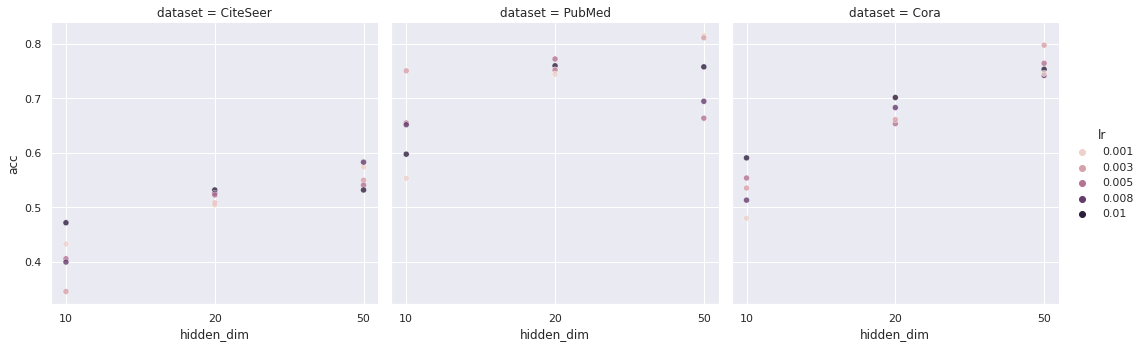

In [7]:
sns.set()
sns.relplot(
        data=df_gnn_test[(df_gnn_test['weight_decay']==0.0)&(df_gnn_test['dropout']==0.0)],
        x="hidden_dim", y="acc", col = "dataset", hue="lr", alpha = .8
    )

## Learning rate

In [16]:
# Fix weight decay, dropout
ranges = ranges_all.copy()
ranges['weight_decay'] = [0.0]
ranges['dropout'] = [0.0]
ranges['hidden_dim'] = {'50': {'output_dim': [50]}}

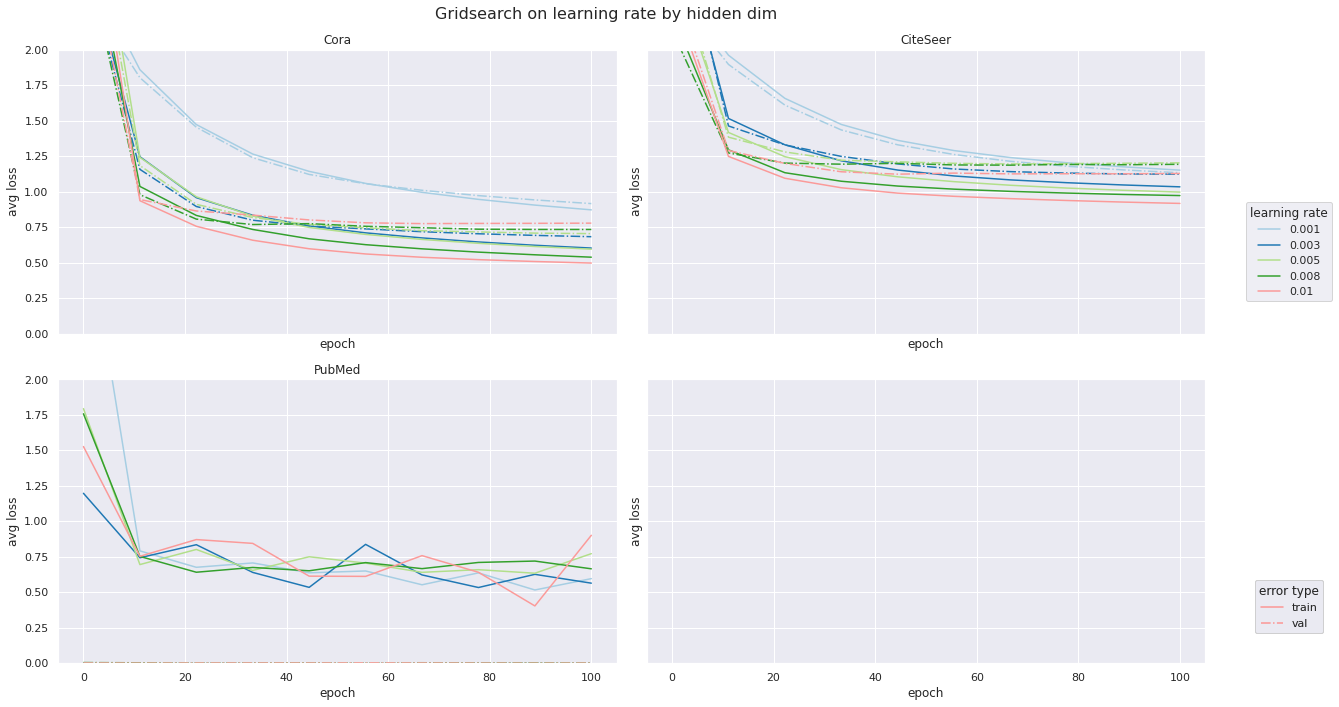

In [18]:
sns.set()
palette = sns.color_palette("Paired", 25)

fig, axs = plt.subplots(2, 2, figsize = (17,10), sharex=True, sharey=True)
plt.rcParams['axes.grid'] = True
plot_lines = []
for params_set in enumerateParams(ranges):
    key = name.format(**params_set)
    v = logs[key]
    if v.empty == False:
        val_losses = v["val_err"][:10]
        train_losses = v["train_err"][:10]
        nepochs = np.linspace(0, len(val_losses)*10, 10)
        dataset = params_set['dataset']
        
        lr = params_set['lr']
        i = ranges['lr'].index(lr)
        
        if dataset=='Cora':
            l1, = axs[0,0].plot(nepochs, train_losses, label=lr, c = palette[i])
            l2, = axs[0,0].plot(nepochs, val_losses, c = palette[i], ls ='dashdot')
            plot_lines += [l1]

        elif dataset=='CiteSeer':
            l1, = axs[0,1].plot(nepochs, train_losses, label=lr, c = palette[i])
            l2, = axs[0,1].plot(nepochs, val_losses, c = palette[i], ls ='dashdot')

        elif dataset=='PubMed':
            l1, = axs[1,0].plot(nepochs, train_losses, label=lr, c = palette[i])
            l2, = axs[1,0].plot(nepochs, val_losses, c = palette[i], ls ='dashdot')

        else:
            print('Not an neural net')
        


axs[0,0].set_title("Cora")
axs[0,1].set_title("CiteSeer")
axs[1,0].set_title("PubMed")

# set labels
plt.setp(axs, xlabel="epoch")
plt.setp(axs, ylabel="avg loss")

legend1 = plt.legend(plot_lines, ranges['lr'], bbox_to_anchor=(1.15, 1.45), loc = 'center', title='learning rate')
plt.gca().add_artist(legend1)

legend2 = plt.legend([l1, l2], ['train', 'val'], title='error type', bbox_to_anchor=(1.15, 0.2), loc = 'center')
plt.gca().add_artist(legend2)

fig.suptitle('Gridsearch on learning rate by hidden dim', fontsize=16)
plt.grid(True)
plt.ylim(0,2)
plt.tight_layout()
plt.show()

## Weight decay

In [19]:
# Fix lr, weight decay, hidden_dim
ranges = ranges_all.copy()
ranges['lr'] = [0.001]
ranges['dropout'] = [0.0]
ranges['hidden_dim'] = {'50': {'output_dim': [50]}}

In [20]:
pal = sns.color_palette("Paired", 25)
fig, axs = plt.subplots(2, 2, figsize = (17,10), sharex=True, sharey=True)
plt.rcParams['axes.grid'] = True
plot_lines = []
for params_set in enumerateParams(ranges):
    key = name.format(**params_set)
    v = logs[key]
    if v.empty == False:
        val_losses = v["val_err"][:10]
        train_losses = v["train_err"][:10]
        nepochs = np.linspace(0, len(val_losses)*10, 10)
        dataset = params_set['dataset']
        
        wd = params_set['weight_decay']
        i = int(ranges['weight_decay'].index(wd))
        
        if dataset=='Cora':
            l1, = axs[0,0].plot(nepochs, train_losses, label=wd, c = pal[i])
            l2, = axs[0,0].plot(nepochs, val_losses, c = pal[i], ls ='dashdot')
            plot_lines += [l1]

        elif dataset=='CiteSeer':
            l1, = axs[0,1].plot(nepochs, train_losses, label=wd, c = pal[i])
            l2, = axs[0,1].plot(nepochs, val_losses, c = pal[i], ls ='dashdot')

        elif dataset=='PubMed':
            l1, = axs[1,0].plot(nepochs, train_losses, label=wd, c = pal[i])
            l2, = axs[1,0].plot(nepochs, val_losses, c = pal[i], ls ='dashdot')

        else:
            print('Not an neural net')

axs[0,0].set_title("Cora")
axs[0,1].set_title("CiteSeer")
axs[1,0].set_title("PubMed")
        
# set labels
plt.setp(axs, xlabel="epoch")
plt.setp(axs, ylabel="avg loss")

legend1 = plt.legend(plot_lines, ranges['weight_decay'], bbox_to_anchor=(1.15, 0.7), loc = 'center', title='weight decay')
plt.gca().add_artist(legend1)

legend2 = plt.legend([l1, l2], ['train', 'val'], title='error type', bbox_to_anchor=(1.15, 0.2), loc = 'center')
plt.gca().add_artist(legend2)

fig.suptitle('Gridsearch on weight decay factor', fontsize=16)
plt.grid(True)
#plt.tight_layout()
plt.show()


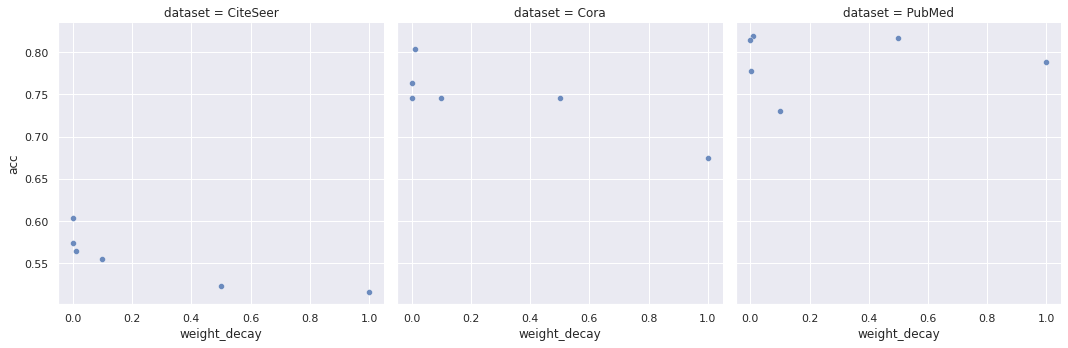

In [23]:
sns.relplot(
        data=df_gnn_test[(df_gnn_test['lr']==0.001)&(df_gnn_test['dropout']==0.0)&(df_gnn_test['hidden_dim']=='50')],
        x="weight_decay", y="acc", col = "dataset", alpha = .8
    )

## Dropout

In [24]:
# Fix lr, weight decay, hidden_dim
ranges = ranges_all.copy()
ranges['lr'] = [0.001]
ranges['weight_decay'] = [0.0]
ranges['hidden_dim'] = {'50': {'output_dim': [50]}}

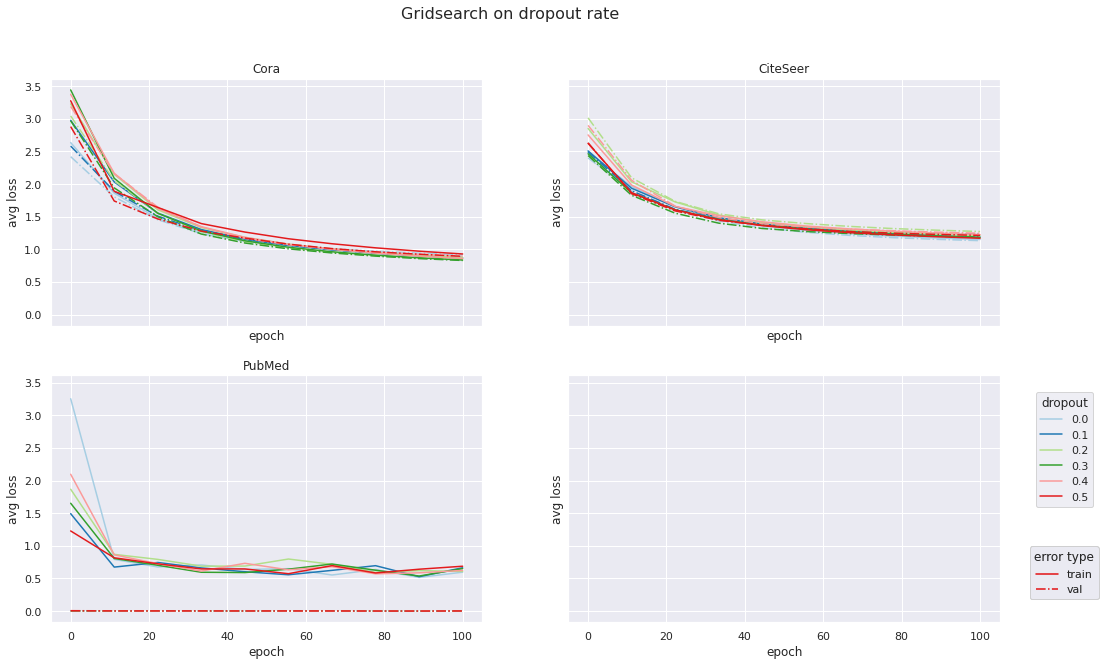

In [25]:
pal = sns.color_palette("Paired", 25)
fig, axs = plt.subplots(2, 2, figsize = (17,10), sharex=True, sharey=True)
plt.rcParams['axes.grid'] = True
plot_lines = []
for params_set in enumerateParams(ranges):
    key = name.format(**params_set)
    v = logs[key]
    if v.empty == False:
        val_losses = v["val_err"][:10]
        train_losses = v["train_err"][:10]
        nepochs = np.linspace(0, len(val_losses)*10, 10)
        dataset = params_set['dataset']
        
        dropout = params_set['dropout']
        i = int(ranges['dropout'].index(dropout))
        
        if dataset=='Cora':
            l1, = axs[0,0].plot(nepochs, train_losses, label=dropout, c = pal[i])
            l2, = axs[0,0].plot(nepochs, val_losses, c = pal[i], ls ='dashdot')
            plot_lines += [l1]

        elif dataset=='CiteSeer':
            l1, = axs[0,1].plot(nepochs, train_losses, label=dropout, c = pal[i])
            l2, = axs[0,1].plot(nepochs, val_losses, c = pal[i], ls ='dashdot')

        elif dataset=='PubMed':
            l1, = axs[1,0].plot(nepochs, train_losses, label=dropout, c = pal[i])
            l2, = axs[1,0].plot(nepochs, val_losses, c = pal[i], ls ='dashdot')

        else:
            print('Not an neural net')

axs[0,0].set_title("Cora")
axs[0,1].set_title("CiteSeer")
axs[1,0].set_title("PubMed")
        
# set labels
plt.setp(axs, xlabel="epoch")
plt.setp(axs, ylabel="avg loss")

legend1 = plt.legend(plot_lines, ranges['dropout'], bbox_to_anchor=(1.15, 0.7), loc = 'center', title='dropout')
plt.gca().add_artist(legend1)

legend2 = plt.legend([l1, l2], ['train', 'val'], title='error type', bbox_to_anchor=(1.15, 0.2), loc = 'center')
plt.gca().add_artist(legend2)

fig.suptitle('Gridsearch on dropout rate', fontsize=16)
plt.grid(True)
#plt.tight_layout()
plt.show()


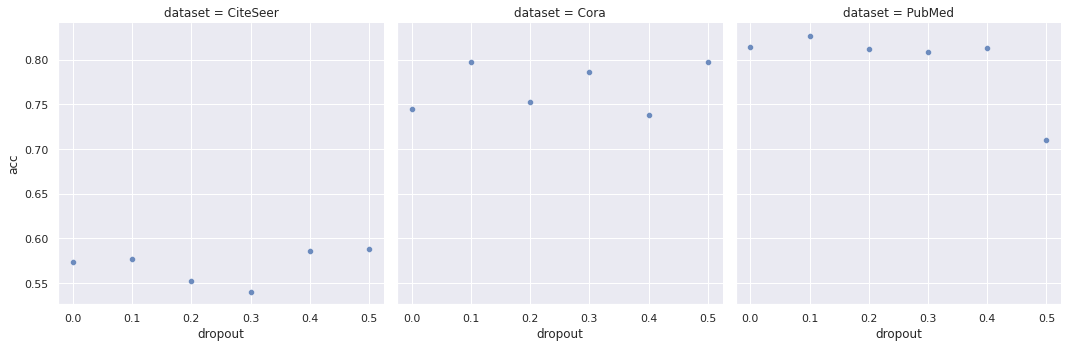

In [26]:
sns.relplot(
        data=df_gnn_test[(df_gnn_test['lr']==0.001)&(df_gnn_test['weight_decay']==0.0)&(df_gnn_test['hidden_dim']=='50')],
        x="dropout", y="acc", col = "dataset", alpha = .8
    )